# Random Forest! :D

## Preprocessing data
1. Load in CSV files.
2. Change column names to merge later.
3. Add in tfidf features + miscellaneous features. Do dimensionality reduction (LSA) on tfidf features.
4. Get rid of low variance users.
5. Get rid of NaN values.
6. One last round of feature selection via LASSO.
<p>.... and then we're done (sigh)

In [1]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

import random
from sklearn import preprocessing

random.seed(2)

In [2]:
rater_df = pd.read_csv("JokeRater.csv")
rating_df = pd.read_csv("JokeRating.csv")
joke_df = pd.read_csv("Joke.csv")

rater_df.rename(columns = {'id':'joke_rater_id'}, inplace = True)
joke_df.rename(columns = {'id':'joke_id'}, inplace = True)
joke_df['joke_id'] = joke_df['joke_id'].astype(float)
rater_df = rater_df.drop('joke_submitter_id', axis=1)
joke_df = joke_df.drop('joke_submitter_id', axis=1)
joke_df = joke_df.drop('joke_source', axis=1)

----
### Incorporating Features

In [3]:
def lsa_fn(X_tfidf, dim_reduce = 20):
    from sklearn.decomposition import TruncatedSVD 
    from sklearn.preprocessing import Normalizer
    """
    INPUT:
    
    dim_reduce: the number of columns you expect for the results
    X_tfidf: ti-idf matrix 
    
    OUTPUT:
    matrix with reduced dim (should be number_of_jokes x dim_reduce) 
    """
    
    lsa = TruncatedSVD(dim_reduce, algorithm = 'arpack')

    # X_tfidf : 153 x 788 tf-idf matrix
    dtm_lsa = lsa.fit_transform(X_tfidf)

    #reduced matrix (combine this matrix w/ other features)
    dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
    
    print(str(lsa.explained_variance_.cumsum()[-1] * 100) + "%")
    
    return(dtm_lsa)

feature_df = pd.read_csv("feature_tfidf.csv")
add_features = feature_df.iloc[:,1:5]

X_tfidf = feature_df.iloc[:,6:]

reduced_tfidf = lsa_fn(X_tfidf, 100) # 79.3% variance explained

79.3245471006%


Using 100 columns from the tfidf columns. Reduced down dimension, got 79.3% variance explained with 100.

In [4]:
tfidf_df = pd.DataFrame(reduced_tfidf)
tfidf_columns = ["tfidf" + str(i) for i in range((tfidf_df.shape[1]))]
tfidf_df.columns = tfidf_columns
feat = pd.concat([add_features, tfidf_df], axis=1)
feat.rename(columns = {'id':'joke_id'}, inplace = True)

joke_df = pd.merge(joke_df, feat, on='joke_id', how='outer')
feat.head()

,joke_id,length,ave_character,ave_word,tfidf0,tfidf1,tfidf2,tfidf3,tfidf4,tfidf5,...,tfidf90,tfidf91,tfidf92,tfidf93,tfidf94,tfidf95,tfidf96,tfidf97,tfidf98,tfidf99
0,505,11,4.727273,5.5,6.620246e-01,3.293859e-01,-2.389910e-01,-1.227327e-01,4.211042e-02,-1.267468e-01,...,8.225381e-16,6.829028e-15,8.530222e-02,4.047082e-02,-4.912029e-02,2.076249e-02,-2.272645e-02,4.705880e-03,-1.008007e-01,-1.993189e-02
1,506,10,6.000000,10.0,5.388173e-03,-7.282967e-03,-4.464966e-03,-5.146563e-03,3.906789e-03,-9.629830e-03,...,3.383072e-18,4.678380e-15,-4.138512e-02,-4.601429e-02,-5.710354e-02,-4.692401e-02,-2.702509e-02,-8.932947e-02,-7.347988e-02,6.487221e-05
2,507,17,4.000000,8.5,1.513910e-02,6.486541e-03,2.018318e-02,4.692381e-02,3.886895e-03,-9.681898e-03,...,4.454194e-16,-1.904457e-15,5.257434e-02,3.367079e-03,1.952242e-02,8.256564e-02,-9.018418e-02,-4.110824e-02,-5.826328e-02,8.898750e-02
3,508,21,4.523810,10.5,1.934393e-01,-3.355115e-02,8.768509e-02,-4.540663e-02,1.470479e-01,-1.769802e-01,...,-2.142130e-15,-2.643978e-14,-1.707641e-01,-9.478652e-02,-6.879718e-02,9.383712e-02,-1.118140e-01,4.154365e-02,1.248751e-01,-6.191568e-02
4,509,9,4.666667,9.0,8.621919e-17,-2.467479e-16,3.583252e-17,4.727794e-17,-1.755476e-16,-5.684259e-17,...,-2.540412e-17,1.663070e-16,-6.138336e-17,-4.702061e-17,1.437249e-16,7.331667e-17,3.502810e-17,9.737678e-17,-6.426634e-18,-6.449480e-19


Dealing with <b>low variance</b> users

In [5]:
df = pd.merge(rating_df, rater_df, on="joke_rater_id", how="outer")
df = df.drop('id', axis=1)
print(df.shape)

user_var = {}
for rater in df.joke_rater_id.unique():
    entries = df[(df['joke_rater_id']==rater)]
    ratings = entries.rating
    var = np.nanvar(ratings)
    if np.isnan(var) == False:
        user_var[rater] = var
        #print(str(rater) + ": " + str(np.nanvar(ratings)))
        
bad_keys = dict((k, v) for k, v in user_var.items() if v < 0.4).keys()
print(bad_keys) # these are the low variance users

df = df[~df['joke_rater_id'].isin(bad_keys)].reset_index(drop=True) # remove low variance users
df = df.loc[0:13398] # remove single entry NaN users
print(df.shape)

(14338, 12)
dict_keys([539, 492, 567, 566, 459, 488])
(13399, 12)


C:\Users\Cindy\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: Degrees of freedom <= 0 for slice.


In [6]:
df = pd.merge(df, joke_df, on='joke_id', how='outer')
df.shape

(13399, 119)

#### Deal with NA's.

In [179]:
def impute_NA(df):
    which_drop = df[df.isnull().sum(axis=1) > 2].index
    new_df = df.drop(which_drop)

    modes = new_df.mode()
    new_df.birth_country = new_df.birth_country.fillna("United States")
    new_df.preferred_joke_type = new_df.preferred_joke_type.fillna("Puns")
    new_df.preferred_joke_genre2 = new_df.preferred_joke_genre.fillna("Programming")
    new_df = new_df.drop(new_df[new_df.joke_type.isnull() == True].index)
    new_df.subject = new_df.subject.fillna('0')
    
    return new_df


df = impute_NA(df)

### Dummies

In [85]:
ignore_col = [i for i in range((df.shape[1])) if (df.iloc[:,i].dtype == np.int64) or (df.iloc[:,i].dtype == np.float64)]
ignore_col.extend([1, 14, 15])
ignore_col = sorted(ignore_col)

In [86]:
#new_df.iloc[:,string_col] = pd.get_dummies(new_df.iloc[:,string_col])
string_col = []
for i in range((df.shape[1])):
    if i not in ignore_col:
        string_col.append(i)
# same thing as
#string_col = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [151]:
df2 = pd.concat([df.iloc[:,ignore_col], pd.get_dummies(df.iloc[:,string_col])], axis=1)

### LASSO

In [153]:
disclude_col = [0, 1, 2, 4, 5]
cols = [i for i in range(df2.shape[1]) if i not in disclude_col] # excluding text, subject, and ID's
#cols = [i for j in (range(3, 4), range(6, 112)) for i in j] 
features = df2.columns[cols]

Index(['age', 'length', 'ave_character', 'ave_word', 'tfidf0', 'tfidf1',
       'tfidf2', 'tfidf3', 'tfidf4', 'tfidf5',
       ...
       'joke_type_Punch line', 'joke_type_Punch-line', 'joke_type_Question',
       'joke_type_Silly', 'joke_type_one-liner', 'joke_type_other',
       'joke_type_pun', 'joke_type_punch line', 'joke_type_question',
       'joke_type_story'],
      dtype='object', length=210)

In [392]:
temp = df2[df2.joke_rater_id == 476]
joke_ids = temp.joke_id # used later when querying new person

In [181]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

lasso = Lasso(alpha=.001, random_state=2).fit(df2[features], df2.rating)
model = SelectFromModel(lasso, prefit=True)
#model.fit(df2[features], df2.rating)

print(df2[features].shape)
print(model.transform(df2[features]).shape)

lasso_X = model.transform(df2[features])

new_features = ["rating", "joke_rater_id"]
for i, feature in zip(model.get_support(), features):
    if i:
        new_features.append(feature)

df3 = pd.concat([df2.rating.reset_index(), df2.joke_rater_id.reset_index(), pd.DataFrame(lasso_X)], axis=1)
df3 = df3.drop('index', axis=1)
df3.columns = new_features
#df3.head()

(13305, 210)
(13305, 131)


### Random Forest implementation

Dividing dataframe into train and test by user.

In [196]:
train_size = round(len(rater_df) * 0.85) # 85/15 train/test split!

unique_rater = df3.joke_rater_id.unique()

train_idx = np.random.choice(unique_rater, train_size)
test_idx = [i for i in unique_rater if i not in train_idx]

train_df = df3.loc[df3['joke_rater_id'].isin(train_idx)]
test_df = df3.loc[df3['joke_rater_id'].isin(test_idx)]

In [390]:
def mse(predicted, real):
    real = np.array(real)
    predicted = np.array(predicted)
    temp =  (real - predicted) * (real - predicted)
    n = len(real)
    mse = 1.0 / n * sum(temp)
    return mse

In [391]:
y = train_df.rating
Y_list = list(y.values)
new_cols = range(2, df3.shape[1])
features = train_df.columns[new_cols]

rf = RandomForestRegressor(n_estimators=50, max_features='sqrt', random_state=42, max_depth=10)
rf.fit(train_df[features], y) # fitting random forest on train data
#mse(y, rf.predict(train_df[features]).astype('float'))

# testing
rf.predict(test_df[features]).astype('float')
mse(test_df.rating, rf.predict(test_df[features]).astype('float'))

1.5100641685051459

#### Distribution of predicted joke score vs. actual joke values.

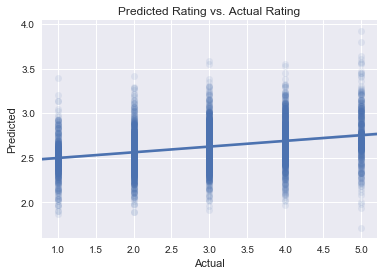

In [411]:
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt

y_test = test_df.rating
y_pred = rf.predict(test_df[features])
ax = sns.regplot(x=y_test, y=y_pred.astype('float'), scatter_kws={'alpha':0.1})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted Rating vs. Actual Rating")
plt.show()

In [272]:
# see what factors are most important
s = pd.DataFrame((rf.feature_importances_))

s = s.transpose()
s.columns = features
s = s.transpose()

s.sort_values(by=0, ascending=False).head(15)

,0
age,0.101888
preferred_joke_genre2_Math,0.038522
preferred_joke_genre_Math,0.034288
gender_Female,0.031661
major_Physics,0.024822
favorite_music_genre_Classical,0.020893
tfidf79,0.015543
length,0.013945
preferred_joke_type_Dialogue,0.013486
favorite_movie_genre_Action,0.012891


-----
#### Querying prediction for new users
Need: age, gender, birth_country, major, joke_rater_id

In [388]:
# convert data into one-hot

# assume data is a dict user_dict
def convert_sample_onehot(user_dict, df=df3):
    '''
    Works with new user or existing user.
    Input: rater_id = user_dict (age, gender, birth_country, major, id)
           df = combined, cleaned dataframe (df3)
           
    Converts user data into variables inside the dataframe (i.e. df3) so you can pass into the random forest.
    '''
    from itertools import compress
    pd.options.mode.chained_assignment = None
    
    if user_dict['id'] in df.joke_rater_id.unique(): # is user already exists in database
        return df[df.joke_rater_id == user_dict['id']]        
    
    entry = df[df.joke_rater_id == 476] # chose 476 randomly because they rated all 153 jokes
    numRow = entry.shape[0]
    
    if user_dict['gender'] == "Male": # gender
        entry.gender_Female = np.repeat(a=0, repeats=numRow)
    
    entry.age = np.repeat(user_dict['age'], numRow) # age
    entry.joke_rater_id = np.repeat(user_dict['id'], numRow)
    
    ## COUNTRY
    user_country = "birth_country_" + user_dict['birth_country'] # user's country
    avail_countries = list(compress(features, [item.startswith('birth') for item in features])) # country dummies
    country_cols = [i for i, x in enumerate(avail_countries) if x]
    for col in country_cols:
        entry.loc[:, col] = np.repeat(0, numRow) # set all countries to 0 for blank slate
    if user_country in avail_countries:
        entry.loc[:,user_country] = np.repeat(1, numRow) # if user country present, set to 1
           
    ## MAJOR
    user_major = "major_" + user_dict['major'] # user's major
    avail_majors = list(compress(features, [item.startswith('major') for item in features])) # major dummies
    major_cols = [i for i, x in enumerate(avail_majors) if x]
    for col in major_cols:
        entry.loc[:, col] = np.repeat(0, numRow) # set all countries to 0 for blank slate  
        
    if user_major in avail_majors:
        entry.loc[:,user_major] = np.repeat(1, numRow)
        
    return entry

In [405]:
def get_topk_jokes(user_df, rf, k=10, features=features, joke_ids=joke_ids, print_output=True, joke_df=joke_df):
    '''
    Returns top k jokes for user (default=10).
    user_df is output from convert_sample_onehot.
    Assumes random forest rf is already trained.
    '''
    preds = rf.predict(user_df[features])
    
    df = pd.DataFrame(joke_ids)
    df['pred'] = preds
    
    topk_id = list(something.sort_values('pred', ascending=False).head(k)['joke_id'])
    
    if print_output:
        print(pd.merge(joke_df[joke_df.joke_id.isin(top10_id)].iloc[:,0:5], something, on='joke_id', how='inner'))
        
    return df

In [410]:
sample_user = {'major':'Statistics', 'age':24, 'birth_country':"United States", 'gender':"Female", 'id':5}
temp = convert_sample_onehot(sample_user, df3)
preds = get_topk_jokes(temp, rf)

  joke_id     category   joke_type             subject  \
0     514  Programming    Question                Loop   
1     520     Children         Pun               Fruit   
2     535  Programming         pun         Programmers   
3     552    Political   one-liner         Bureaucracy   
4     573     Medicine         Pun          Broken Leg   
5     619          Dad         Pun               Drugs   
6     633     Medicine    question             doctors   
7     649         Math  Punch line  PhD in Mathematics   
8     658    Political   One-liner     Political Jokes   
9     663       School   One-liner   Plagiarism is Bad   

                                           joke_text      pred  
0  Why are 'i' and 'j' a good source of informati...  3.371840  
1  My friend thinks he is smart. He told me an on...  3.352637  
2  Why are Assembly programmers always soaking we...  3.380916  
3  The worst part about working for the departmen...  3.371224  
4  I told the doctor I broke my leg 

In [409]:
preds.head() # top 10 jokes according to ID, and their predicted score

,joke_id,pred
2,527,2.507388
90,592,3.054786
180,552,3.371224
267,588,3.106466
352,589,2.873460


NEED TO: take care of missing values, incorrectly typed values